In [1]:
import numpy as np
import pandas as pd
import time
import random
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers import Input, Conv2D
from keras.models import Model
from keras.models import load_model
from keras import optimizers
from scipy import ndimage, misc
import gym
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def plot_state(obs):
    plt.figure(figsize=(12,8))
    plt.imshow(obs)
    plt.axis("off")
    plt.show()

In [3]:
def process_obs(obs):
    obs = obs.max(axis=-1,keepdims=1)
    obs = obs.reshape((210,160))
    obs = misc.imresize(obs, (110,84))
    lives = obs[2:9,52:59]
    obs = obs[18:102,:,]
    obs = np.expand_dims(obs,2)
    obs = obs.astype(np.uint8) / 255
    obs[obs > 0] = 1
    return [obs,lives]

Welcome to AI Breakout!
Starting Test Game...



/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


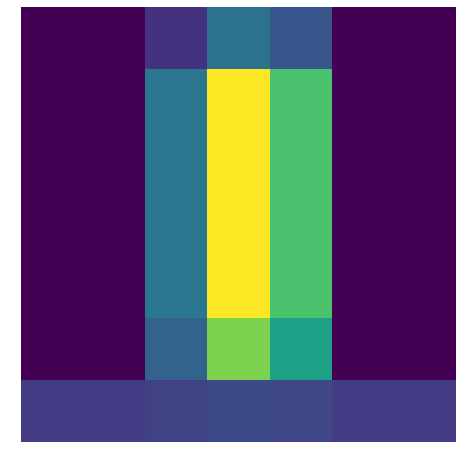

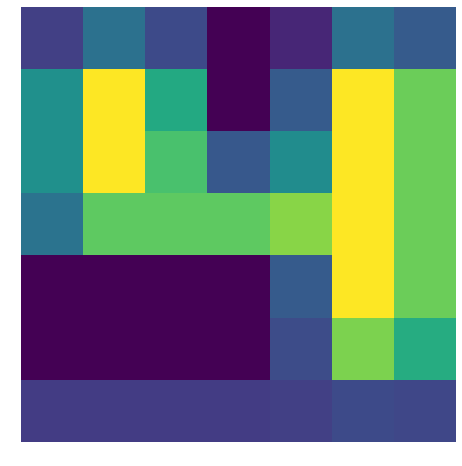

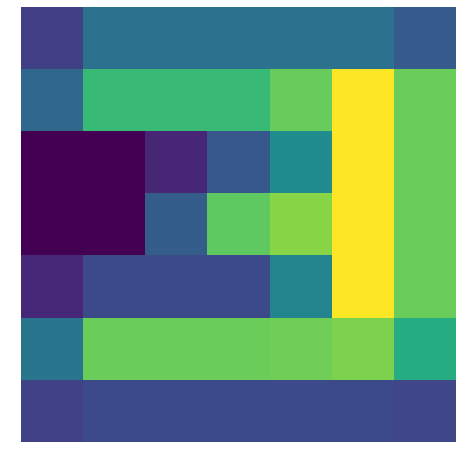

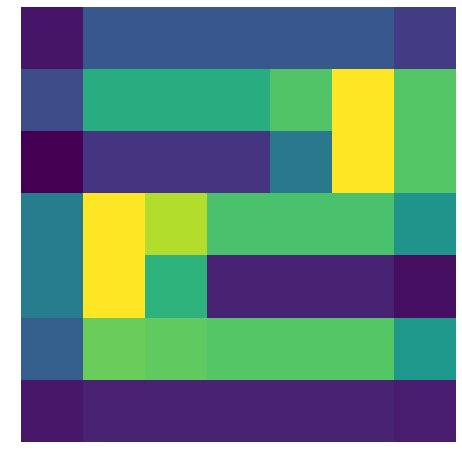

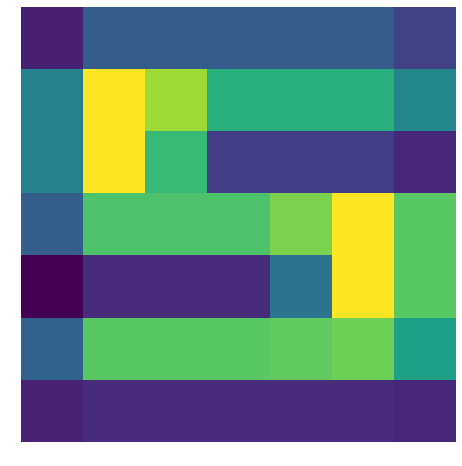

In [4]:
episodes = 1
env = gym.make("Breakout-v0")
init = env.reset()

for i in range(episodes):
    print("Welcome to AI Breakout!")
    print("Starting Test Game...\n")

    
    game = True
    LIVES = []
    while game:
        
        action = env.action_space.sample()
        
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        LIVES.append(lives)
        
        if done:
            
            LIVES = np.unique(np.array(LIVES), axis=0)
            
            for i in LIVES:
                plot_state(i.reshape(7,7))
            game = False
            observation = env.reset()
                             
        else:
            pass
            
         

In [5]:
env = gym.make("Breakout-v0")
init = env.reset()

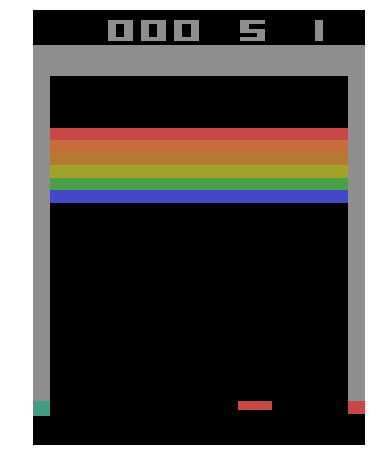

In [6]:
plot_state(init)

In [7]:
init.shape

(210, 160, 3)

In [8]:
I = process_obs(init)[0]

/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


In [9]:
I.shape

(84, 84, 1)

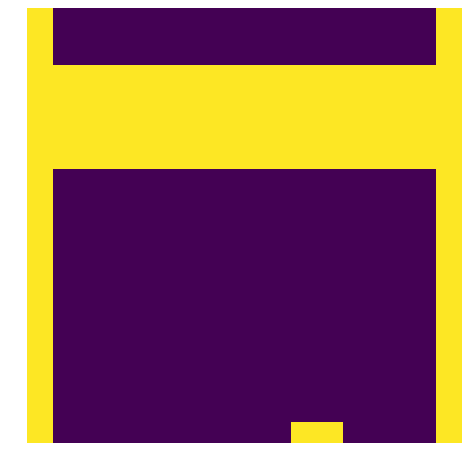

In [10]:
plot_state(I.reshape(84,84))

In [11]:
env.action_space

Discrete(4)

In [12]:
inp = Input(shape=(84,84,4))
x = Conv2D(16, (8,8), strides=4, activation="relu", input_shape=(84,84,4))(inp)
x = Conv2D(32, (4,4), strides=2, activation="relu")(x)
x = Flatten()(x)
x = Dense(256,  activation="relu")(x)
output = Dense(env.action_space.n)(x)

model = Model(inp, output)
callbacks_list = [keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.01, patience=2, mode = min, verbose = 1)]
model.compile(loss='mean_squared_error', optimizer=optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=["mae"])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 16)        4112      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 32)          8224      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2592)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               663808    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 677,172
Trainable params: 677,172
Non-trainable params: 0
_________________________________________________________________
None

/Users/samwilliams/homebrew/lib/python3.7/site-packages/keras/callbacks.py:1086: RuntimeWarning: Learning Rate Plateau Reducing mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


In [13]:
LIFE = {}
LIFE["1"] = LIVES[0]
LIFE["2"] = LIVES[3]
LIFE["3"] = LIVES[2]
LIFE["4"] = LIVES[1]
LIFE["5"] = LIVES[4]

In [14]:
for i,j in LIFE.items():
    print(i)

1
2
3
4
5


In [15]:
full_episode_history = {"state" : np.array([]), "reward" : np.array([]), "action": np.array([]), "Q": np.array([])}

In [16]:
env = gym.make("Breakout-v0")
observation = env.reset()
observation, lives = process_obs(observation)

episodes = 1000
episode_scores = []
epsilon = 1
gamma = 0.99
done = False

for i in range(1, episodes+1):
    print("Welcome to AI Breakout!")
    print("Starting Game {} of {}...\n".format(i, episodes))
    
    sum = 0
    frame = 1
    game = True
    LIVES = []
    observation_batch = []
    reward_batch = []
    episode_history = {"state" : np.array([]), "reward" : np.array([]), "action": np.array([]), "Q": np.array([])}

    
    
    while game: 
        
        if (frame == 1):
            action = 1              
        else:
            if (frame - 1) % 4 == 0:
                rand = np.random.uniform(0,1)
                if  rand < epsilon:
                    action = env.action_space.sample()
                else:
                    observation = np.expand_dims(episode_history["state"][-1],0)
                    action = np.argmax(model.predict(observation))
                
                if len(episode_history["state"]) > 2:
                    if np.array_equal(episode_history["state"][-1], episode_history["state"][-2]):
                        action = 1
                    else:
                        pass
                else:
                    pass
                observation_batch = []
                reward_batch = []
                
            else:
                pass
            
        
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        
        if len(LIVES) == 0:
            LIVES.append(lives)
            loss = 0
        else:
            if np.array_equal(LIVES[-1], lives):
                loss = 0
            else:
                LIVES.append(lives)
                loss = -10
                
        observation_batch.append(observation)
        reward_batch.append(10*reward+loss)        
        
        if (frame % 4 == 0):
            if frame == 4:
                episode_history["state"] = np.concatenate([i for i in observation_batch], axis=-1)
                episode_history["state"] = np.expand_dims(episode_history["state"],0)

            else:
                obs = np.concatenate([i for i in observation_batch], axis=-1)
                obs = np.expand_dims(obs,0)
                episode_history["state"] = np.concatenate([episode_history["state"], obs], axis=0)

            episode_history["reward"] = np.concatenate([episode_history["reward"], np.array([np.sum(reward_batch)])], axis = 0)  
            episode_history["action"] = np.concatenate([episode_history["action"], np.array([action])], axis=0)
         
        sum += reward
        frame += 1
        
        
        
        
        if done:

            for j,k in enumerate(episode_history["reward"][::-1]):
                
                if j == 0:
                    val = np.array([[0, 0, 0, 0]], dtype="float32")
                    val[0,int(episode_history["action"][-1])] = k
                    Q = val
                else:
                    val = np.array([[0, 0, 0, 0]], dtype="float32")
                    val[0,int(episode_history["action"][-1-j])] = k + gamma*np.sum(Q[-1])
                    Q = np.concatenate([Q,val], axis = 0)
                    
            Q = Q[::-1]
            episode_history["Q"] = Q
                        
            if i == 1:
                full_episode_history["state"] = episode_history["state"]
                full_episode_history["Q"] = episode_history["Q"]
            else:
                full_episode_history["state"] = np.concatenate([full_episode_history["state"], episode_history["state"]], axis = 0)
                full_episode_history["Q"] = np.concatenate([full_episode_history["Q"], episode_history["Q"]], axis = 0)

            full_episode_history["reward"] = np.concatenate([full_episode_history["reward"], episode_history["reward"]], axis = 0)
            full_episode_history["action"] = np.concatenate([full_episode_history["action"], episode_history["action"]], axis = 0)
            
            
            print("Training the model from a random batch...")
            
            rand = np.random.choice([i for i in range(full_episode_history["action"].shape[0])], size=32)
            inp = full_episode_history["state"][rand]
            target = full_episode_history["Q"][rand]
            model.fit(inp, target, epochs = 5, batch_size=8, verbose=0)
            print("Total game score was: {}".format(int(sum)))
            print("Epsilon: {}\n".format(epsilon))
            
            observation = env.reset()
            observation, lives = process_obs(observation)
            episode_scores.append(int(sum))
            epsilon *= 0.999
            if epsilon < 0.1:
                epsilon = 0.1
            game = False
            frame = 0
 
                             
        else:
            pass
            
         

Welcome to AI Breakout!
Starting Game 1 of 1000...



/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 8ms/step - loss: 26.8616 - mean_absolute_error: 2.3792
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 26.0088 - mean_absolute_error: 2.6149
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 26.1457 - mean_absolute_error: 2.4763
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 26.5795 - mean_absolute_error: 2.6852
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 26.0822 - mean_absolute_error: 2.6159
Total game score was: 2
Epsilon: 1

Welcome to AI Breakout!
Starting Game 2 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 48.0182 - mean_absolute_error: 3.4086
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 46.8159 - mean_absolute_error: 3.7613
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - 

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 41.8477 - mean_absolute_error: 4.4829
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 40.3563 - mean_absolute_error: 3.9578
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 40.0047 - mean_absolute_error: 3.8718
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 39.8497 - mean_absolute_error: 3.8137
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 39.7366 - mean_absolute_error: 3.7920
Total game score was: 2
Epsilon: 0.988065780494209

Welcome to AI Breakout!
Starting Game 14 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 64.5324 - mean_absolute_error: 4.6589
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 64.1325 - mean_absolute_error: 4.8876
Epoch 3/5
32/32 [==============================]

32/32 [==============================] - 0s 1ms/step - loss: 57.8492 - mean_absolute_error: 4.6913
Total game score was: 2
Epsilon: 0.9772512378214517

Welcome to AI Breakout!
Starting Game 25 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 52.7831 - mean_absolute_error: 3.9673
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 52.1421 - mean_absolute_error: 3.8620
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 51.5460 - mean_absolute_error: 3.8116
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 50.9594 - mean_absolute_error: 3.6509
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 50.8569 - mean_absolute_error: 3.7130
Total game score was: 1
Epsilon: 0.9762739865836303

Welcome to AI Breakout!
Starting Game 26 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/st

Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 54.4448 - mean_absolute_error: 4.3737
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 55.0185 - mean_absolute_error: 4.6090
Total game score was: 1
Epsilon: 0.9655885070369844

Welcome to AI Breakout!
Starting Game 37 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 43.5578 - mean_absolute_error: 3.9607
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 42.1097 - mean_absolute_error: 3.6548
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 41.8772 - mean_absolute_error: 3.5381
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 41.6123 - mean_absolute_error: 3.5188
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 41.8047 - mean_absolute_error: 3.4214
Total game score was: 1
Epsilon: 0.9646229185299474

Welcome to AI Breakout!
Starting Gam

32/32 [==============================] - 0s 1ms/step - loss: 42.3709 - mean_absolute_error: 4.2864
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 41.1879 - mean_absolute_error: 4.2978
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 40.6060 - mean_absolute_error: 4.1485
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 40.3883 - mean_absolute_error: 4.2299
Total game score was: 2
Epsilon: 0.9540649618417361

Welcome to AI Breakout!
Starting Game 49 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 61.5473 - mean_absolute_error: 4.9295
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 58.9334 - mean_absolute_error: 4.7840
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 57.6659 - mean_absolute_error: 5.0700
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 56.9530 - mean_absolute_erro

32/32 [==============================] - 0s 2ms/step - loss: 40.3611 - mean_absolute_error: 3.7093
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 36.6061 - mean_absolute_error: 3.6379
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 35.1315 - mean_absolute_error: 3.7725
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 34.4389 - mean_absolute_error: 3.7156
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 34.3678 - mean_absolute_error: 3.8392
Total game score was: 1
Epsilon: 0.9426789411643326

Welcome to AI Breakout!
Starting Game 61 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 40.7551 - mean_absolute_error: 3.7437
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 39.4538 - mean_absolute_error: 3.7180
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 38.6675 - mean_absolute_erro

Welcome to AI Breakout!
Starting Game 72 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 42.4282 - mean_absolute_error: 3.9580
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 40.7959 - mean_absolute_error: 3.9029
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 39.8517 - mean_absolute_error: 3.8058
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 38.9603 - mean_absolute_error: 3.9275
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 37.9869 - mean_absolute_error: 3.7910
Total game score was: 1
Epsilon: 0.9314288037569908

Welcome to AI Breakout!
Starting Game 73 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 51.3767 - mean_absolute_error: 4.0984
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 49.1909 - mean_absolute_error: 4

32/32 [==============================] - 0s 1ms/step - loss: 36.5990 - mean_absolute_error: 3.5332
Total game score was: 2
Epsilon: 0.9212341621210596

Welcome to AI Breakout!
Starting Game 84 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 60.0987 - mean_absolute_error: 4.6656
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 56.9938 - mean_absolute_error: 4.7328
Epoch 3/5
32/32 [==============================] - 0s 3ms/step - loss: 54.6175 - mean_absolute_error: 4.5757
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 53.0251 - mean_absolute_error: 4.8515
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 51.0665 - mean_absolute_error: 4.6304
Total game score was: 4
Epsilon: 0.9203129279589385

Welcome to AI Breakout!
Starting Game 85 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/st

Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 30.4608 - mean_absolute_error: 3.2032
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 29.0157 - mean_absolute_error: 3.2394
Total game score was: 1
Epsilon: 0.9102399514140735

Welcome to AI Breakout!
Starting Game 96 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 47.7164 - mean_absolute_error: 3.7441
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 44.4678 - mean_absolute_error: 3.8416
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 44.2791 - mean_absolute_error: 3.8248
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 42.0265 - mean_absolute_error: 3.8471
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 40.5764 - mean_absolute_error: 3.6974
Total game score was: 2
Epsilon: 0.9093297114626595

Welcome to AI Breakout!
Starting Gam

32/32 [==============================] - 0s 1ms/step - loss: 48.3542 - mean_absolute_error: 3.9801
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 46.1507 - mean_absolute_error: 3.9273
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 45.7837 - mean_absolute_error: 3.9258
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 43.7137 - mean_absolute_error: 3.8373
Total game score was: 1
Epsilon: 0.8993769480309576

Welcome to AI Breakout!
Starting Game 108 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 37.8793 - mean_absolute_error: 3.7917
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 33.6341 - mean_absolute_error: 3.4329
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 32.4231 - mean_absolute_error: 3.4274
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 30.8006 - mean_absolute_err

32/32 [==============================] - 0s 2ms/step - loss: 43.2366 - mean_absolute_error: 3.8263
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 40.8867 - mean_absolute_error: 3.7258
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 39.2658 - mean_absolute_error: 3.4619
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 37.1738 - mean_absolute_error: 3.4794
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 36.1280 - mean_absolute_error: 3.4501
Total game score was: 2
Epsilon: 0.8886435861147077

Welcome to AI Breakout!
Starting Game 120 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 42.5443 - mean_absolute_error: 4.1291
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 40.5820 - mean_absolute_error: 3.9583
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 39.3533 - mean_absolute_err

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 3ms/step - loss: 33.6286 - mean_absolute_error: 3.3931
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 31.2613 - mean_absolute_error: 3.1526
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 30.1124 - mean_absolute_error: 3.0567
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 29.3264 - mean_absolute_error: 3.0233
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 27.9986 - mean_absolute_error: 2.9120
Total game score was: 1
Epsilon: 0.8780383184956015

Welcome to AI Breakout!
Starting Game 132 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 50.5115 - mean_absolute_error: 4.0532
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 44.5379 - mean_absolute_error: 3.8580
Epoch 3/5
32/32 [=============================

32/32 [==============================] - 0s 1ms/step - loss: 27.0059 - mean_absolute_error: 3.1157
Total game score was: 0
Epsilon: 0.8684280445126921

Welcome to AI Breakout!
Starting Game 143 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 52.0736 - mean_absolute_error: 4.2298
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 48.3782 - mean_absolute_error: 4.1298
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 45.0252 - mean_absolute_error: 3.9306
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 44.2083 - mean_absolute_error: 3.9026
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 43.2418 - mean_absolute_error: 3.9674
Total game score was: 0
Epsilon: 0.8675596164681794

Welcome to AI Breakout!
Starting Game 144 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/

32/32 [==============================] - 0s 1ms/step - loss: 36.9366 - mean_absolute_error: 3.5931
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 35.3911 - mean_absolute_error: 3.5964
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 34.1852 - mean_absolute_error: 3.5328
Total game score was: 2
Epsilon: 0.8580640336044925

Welcome to AI Breakout!
Starting Game 155 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 62.7967 - mean_absolute_error: 4.5119
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 58.6627 - mean_absolute_error: 4.4833
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 55.4964 - mean_absolute_error: 4.3872
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 53.7893 - mean_absolute_error: 4.3154
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 51.5101 - mean_absolute_err

32/32 [==============================] - 0s 3ms/step - loss: 25.8881 - mean_absolute_error: 3.0681
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 22.4359 - mean_absolute_error: 2.7032
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 21.0660 - mean_absolute_error: 2.5475
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 20.0574 - mean_absolute_error: 2.5110
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 18.9913 - mean_absolute_error: 2.3904
Total game score was: 3
Epsilon: 0.847823709077432

Welcome to AI Breakout!
Starting Game 167 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 26.3682 - mean_absolute_error: 2.9035
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 24.1382 - mean_absolute_error: 2.7983
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 22.5861 - mean_absolute_erro

32/32 [==============================] - 0s 1ms/step - loss: 24.0413 - mean_absolute_error: 2.8939
Total game score was: 3
Epsilon: 0.838544138970058

Welcome to AI Breakout!
Starting Game 178 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 24.2490 - mean_absolute_error: 2.7707
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 23.0400 - mean_absolute_error: 2.6531
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 21.7466 - mean_absolute_error: 2.5656
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 20.9297 - mean_absolute_error: 2.4908
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 20.2382 - mean_absolute_error: 2.4265
Total game score was: 3
Epsilon: 0.8377055948310879

Welcome to AI Breakout!
Starting Game 179 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/s

32/32 [==============================] - 0s 1ms/step - loss: 29.6477 - mean_absolute_error: 3.2968
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 27.6216 - mean_absolute_error: 3.0779
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 26.1363 - mean_absolute_error: 2.9810
Total game score was: 2
Epsilon: 0.8285367691502946

Welcome to AI Breakout!
Starting Game 190 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 49.0604 - mean_absolute_error: 4.1533
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 43.5912 - mean_absolute_error: 3.9773
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 41.2471 - mean_absolute_error: 3.8513
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 38.7711 - mean_absolute_error: 3.7061
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 36.9743 - mean_absolute_err

32/32 [==============================] - 0s 2ms/step - loss: 37.1241 - mean_absolute_error: 3.7351
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 33.5947 - mean_absolute_error: 3.3570
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 31.6504 - mean_absolute_error: 3.2299
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 29.8785 - mean_absolute_error: 3.2146
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 28.9932 - mean_absolute_error: 3.1124
Total game score was: 1
Epsilon: 0.818648829478636

Welcome to AI Breakout!
Starting Game 202 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 43.3202 - mean_absolute_error: 3.7574
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 39.2556 - mean_absolute_error: 3.6717
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 36.3492 - mean_absolute_erro

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 49.9466 - mean_absolute_error: 4.0615
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 44.2428 - mean_absolute_error: 3.8077
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 40.8454 - mean_absolute_error: 3.6120
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 37.9695 - mean_absolute_error: 3.6845
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 34.8170 - mean_absolute_error: 3.5022
Total game score was: 1
Epsilon: 0.8088788946494789

Welcome to AI Breakout!
Starting Game 214 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 51.5743 - mean_absolute_error: 4.2352
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 46.3454 - mean_absolute_error: 3.9920
Epoch 3/5
32/32 [=============================

32/32 [==============================] - 0s 1ms/step - loss: 33.2115 - mean_absolute_error: 3.3495
Total game score was: 0
Epsilon: 0.8000255819490795

Welcome to AI Breakout!
Starting Game 225 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 41.0868 - mean_absolute_error: 3.6824
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 35.5175 - mean_absolute_error: 3.5750
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 32.0215 - mean_absolute_error: 3.4197
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 29.4029 - mean_absolute_error: 3.2710
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 26.9518 - mean_absolute_error: 3.2061
Total game score was: 0
Epsilon: 0.7992255563671304

Welcome to AI Breakout!
Starting Game 226 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/

32/32 [==============================] - 0s 1ms/step - loss: 32.5330 - mean_absolute_error: 3.5368
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 30.2120 - mean_absolute_error: 3.4040
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 28.4901 - mean_absolute_error: 3.2656
Total game score was: 1
Epsilon: 0.790477901043851

Welcome to AI Breakout!
Starting Game 237 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 36.1330 - mean_absolute_error: 3.7408
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 32.3278 - mean_absolute_error: 3.3369
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 29.2625 - mean_absolute_error: 3.2485
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 28.2696 - mean_absolute_error: 3.2083
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 26.3512 - mean_absolute_erro

32/32 [==============================] - 0s 2ms/step - loss: 37.5484 - mean_absolute_error: 3.4515
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 32.8334 - mean_absolute_error: 3.2902
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 30.0657 - mean_absolute_error: 3.0502
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 27.5811 - mean_absolute_error: 2.9564
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 25.9142 - mean_absolute_error: 2.8591
Total game score was: 2
Epsilon: 0.7810441642583167

Welcome to AI Breakout!
Starting Game 249 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 3ms/step - loss: 28.0035 - mean_absolute_error: 3.1627
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 25.0854 - mean_absolute_error: 2.7549
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 23.1583 - mean_absolute_err

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 39.5774 - mean_absolute_error: 3.7992
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 31.9042 - mean_absolute_error: 3.5329
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 27.4997 - mean_absolute_error: 3.1112
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 24.6885 - mean_absolute_error: 3.0570
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 22.1901 - mean_absolute_error: 2.9169
Total game score was: 1
Epsilon: 0.7717230117583408

Welcome to AI Breakout!
Starting Game 261 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 39.2401 - mean_absolute_error: 3.6941
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 33.5861 - mean_absolute_error: 3.2761
Epoch 3/5
32/32 [=============================

32/32 [==============================] - 0s 1ms/step - loss: 25.4243 - mean_absolute_error: 2.7902
Total game score was: 1
Epsilon: 0.7632763763146613

Welcome to AI Breakout!
Starting Game 272 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 59.6204 - mean_absolute_error: 4.3500
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 53.7633 - mean_absolute_error: 4.1848
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 50.9968 - mean_absolute_error: 4.3333
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 48.1514 - mean_absolute_error: 4.0823
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 45.3695 - mean_absolute_error: 3.9957
Total game score was: 2
Epsilon: 0.7625130999383466

Welcome to AI Breakout!
Starting Game 273 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/

32/32 [==============================] - 0s 2ms/step - loss: 37.4062 - mean_absolute_error: 3.5503
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 35.7521 - mean_absolute_error: 3.4586
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 34.1391 - mean_absolute_error: 3.4016
Total game score was: 2
Epsilon: 0.7541672684961374

Welcome to AI Breakout!
Starting Game 284 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 41.0893 - mean_absolute_error: 3.7763
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 36.9411 - mean_absolute_error: 3.5778
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 34.6344 - mean_absolute_error: 3.5041
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 32.2213 - mean_absolute_error: 3.3734
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 30.0824 - mean_absolute_err

32/32 [==============================] - 0s 2ms/step - loss: 37.9979 - mean_absolute_error: 3.7898
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 31.5390 - mean_absolute_error: 3.6288
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 28.1291 - mean_absolute_error: 3.6427
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 25.3376 - mean_absolute_error: 3.3040
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 24.4688 - mean_absolute_error: 3.3371
Total game score was: 0
Epsilon: 0.7451668707698216

Welcome to AI Breakout!
Starting Game 296 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 43.9979 - mean_absolute_error: 4.1463
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 35.9236 - mean_absolute_error: 3.6189
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 32.7060 - mean_absolute_err

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 3ms/step - loss: 30.2768 - mean_absolute_error: 3.0685
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 26.0755 - mean_absolute_error: 2.9515
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 23.9432 - mean_absolute_error: 2.8902
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 22.3212 - mean_absolute_error: 2.8578
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 20.9815 - mean_absolute_error: 2.8116
Total game score was: 1
Epsilon: 0.7362738857656108

Welcome to AI Breakout!
Starting Game 308 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 51.1100 - mean_absolute_error: 4.2407
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 45.7994 - mean_absolute_error: 3.9899
Epoch 3/5
32/32 [=============================

32/32 [==============================] - 0s 1ms/step - loss: 27.7790 - mean_absolute_error: 3.2738
Total game score was: 0
Epsilon: 0.7282152468433455

Welcome to AI Breakout!
Starting Game 319 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 40.8614 - mean_absolute_error: 3.6978
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 35.5564 - mean_absolute_error: 3.3807
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 32.6623 - mean_absolute_error: 3.2251
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 30.4605 - mean_absolute_error: 3.1335
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 27.9307 - mean_absolute_error: 3.0455
Total game score was: 1
Epsilon: 0.7274870315965022

Welcome to AI Breakout!
Starting Game 320 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/

32/32 [==============================] - 0s 1ms/step - loss: 37.8774 - mean_absolute_error: 3.9648
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 35.2852 - mean_absolute_error: 3.7507
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 33.8295 - mean_absolute_error: 3.6772
Total game score was: 1
Epsilon: 0.7195245662400531

Welcome to AI Breakout!
Starting Game 331 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 37.2049 - mean_absolute_error: 3.6562
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 33.2377 - mean_absolute_error: 3.3742
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 29.9292 - mean_absolute_error: 3.1816
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 27.8560 - mean_absolute_error: 3.0684
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 25.6841 - mean_absolute_err

32/32 [==============================] - 0s 2ms/step - loss: 52.5772 - mean_absolute_error: 4.2998
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 46.0177 - mean_absolute_error: 3.9915
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 41.5096 - mean_absolute_error: 3.8542
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 39.2800 - mean_absolute_error: 3.7199
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 36.1143 - mean_absolute_error: 3.5835
Total game score was: 3
Epsilon: 0.7109376021267352

Welcome to AI Breakout!
Starting Game 343 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 51.4212 - mean_absolute_error: 4.0278
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 44.5180 - mean_absolute_error: 3.7791
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 40.3395 - mean_absolute_err

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 48.2248 - mean_absolute_error: 4.2314
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 44.4860 - mean_absolute_error: 3.9512
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 40.0560 - mean_absolute_error: 3.7879
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 37.7739 - mean_absolute_error: 3.5448
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 35.0682 - mean_absolute_error: 3.5292
Total game score was: 0
Epsilon: 0.7024531167280339

Welcome to AI Breakout!
Starting Game 355 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 47.3762 - mean_absolute_error: 3.9792
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 41.2419 - mean_absolute_error: 3.6012
Epoch 3/5
32/32 [=============================

32/32 [==============================] - 0s 1ms/step - loss: 35.1848 - mean_absolute_error: 3.1769
Total game score was: 0
Epsilon: 0.6947646516921667

Welcome to AI Breakout!
Starting Game 366 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 34.3536 - mean_absolute_error: 3.4067
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 29.7240 - mean_absolute_error: 3.2283
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 26.2685 - mean_absolute_error: 3.0543
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 23.8844 - mean_absolute_error: 2.9772
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 21.5887 - mean_absolute_error: 2.8392
Total game score was: 3
Epsilon: 0.6940698870404746

Welcome to AI Breakout!
Starting Game 367 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/

32/32 [==============================] - 0s 1ms/step - loss: 39.8386 - mean_absolute_error: 3.8136
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 37.3291 - mean_absolute_error: 3.6986
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 34.6844 - mean_absolute_error: 3.5525
Total game score was: 1
Epsilon: 0.686473177834008

Welcome to AI Breakout!
Starting Game 378 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 28.4974 - mean_absolute_error: 3.2934
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 25.3366 - mean_absolute_error: 3.0414
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 22.6629 - mean_absolute_error: 2.9030
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 20.9962 - mean_absolute_error: 2.7963
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 19.7014 - mean_absolute_erro

32/32 [==============================] - 0s 2ms/step - loss: 34.0322 - mean_absolute_error: 3.6197
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 29.8498 - mean_absolute_error: 3.5493
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 28.1038 - mean_absolute_error: 3.3691
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 26.2578 - mean_absolute_error: 3.3411
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 24.3374 - mean_absolute_error: 3.2275
Total game score was: 0
Epsilon: 0.6782806562448989

Welcome to AI Breakout!
Starting Game 390 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 56.7962 - mean_absolute_error: 4.3937
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 49.5409 - mean_absolute_error: 3.8839
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 45.1438 - mean_absolute_err

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 33.5159 - mean_absolute_error: 3.4611
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 27.9346 - mean_absolute_error: 3.1402
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 25.4940 - mean_absolute_error: 2.9888
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 22.9774 - mean_absolute_error: 2.8413
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 21.2953 - mean_absolute_error: 2.6821
Total game score was: 0
Epsilon: 0.6701859060067403

Welcome to AI Breakout!
Starting Game 402 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 44.9485 - mean_absolute_error: 4.0001
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 39.3872 - mean_absolute_error: 3.6246
Epoch 3/5
32/32 [=============================

32/32 [==============================] - 0s 2ms/step - loss: 29.2270 - mean_absolute_error: 3.1026
Total game score was: 0
Epsilon: 0.662850610905674

Welcome to AI Breakout!
Starting Game 413 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 32.0867 - mean_absolute_error: 3.1419
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 27.1120 - mean_absolute_error: 2.9102
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 24.4081 - mean_absolute_error: 2.8041
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 22.0308 - mean_absolute_error: 2.6776
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 20.0589 - mean_absolute_error: 2.6431
Total game score was: 1
Epsilon: 0.6621877602947683

Welcome to AI Breakout!
Starting Game 414 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/s

32/32 [==============================] - 0s 2ms/step - loss: 39.1311 - mean_absolute_error: 3.4499
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 36.1076 - mean_absolute_error: 3.3396
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 33.4452 - mean_absolute_error: 3.2477
Total game score was: 4
Epsilon: 0.654940006215578

Welcome to AI Breakout!
Starting Game 425 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 37.3480 - mean_absolute_error: 3.7703
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 30.6720 - mean_absolute_error: 3.3967
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 26.2983 - mean_absolute_error: 3.2380
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 22.8815 - mean_absolute_error: 2.9524
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 20.5867 - mean_absolute_erro

32/32 [==============================] - 0s 2ms/step - loss: 34.9795 - mean_absolute_error: 3.5464
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 30.0882 - mean_absolute_error: 3.4217
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 26.1014 - mean_absolute_error: 3.1151
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 23.8584 - mean_absolute_error: 3.0104
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 21.4946 - mean_absolute_error: 2.9480
Total game score was: 1
Epsilon: 0.647123808418277

Welcome to AI Breakout!
Starting Game 437 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 36.6858 - mean_absolute_error: 3.9633
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 30.7357 - mean_absolute_error: 3.7432
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 27.2557 - mean_absolute_erro

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 42.1719 - mean_absolute_error: 3.7051
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 35.5779 - mean_absolute_error: 3.5227
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 32.1586 - mean_absolute_error: 3.2477
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 29.7301 - mean_absolute_error: 3.1977
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 26.8436 - mean_absolute_error: 2.9730
Total game score was: 0
Epsilon: 0.6394008908411897

Welcome to AI Breakout!
Starting Game 449 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 45.0044 - mean_absolute_error: 3.8170
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 38.7921 - mean_absolute_error: 3.5122
Epoch 3/5
32/32 [=============================

32/32 [==============================] - 0s 1ms/step - loss: 30.1930 - mean_absolute_error: 3.1724
Total game score was: 2
Epsilon: 0.632402542800493

Welcome to AI Breakout!
Starting Game 460 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 34.1943 - mean_absolute_error: 3.3620
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 30.7469 - mean_absolute_error: 3.2863
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 28.1760 - mean_absolute_error: 3.0957
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 26.4608 - mean_absolute_error: 2.9967
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 25.0422 - mean_absolute_error: 2.8974
Total game score was: 1
Epsilon: 0.6317701402576925

Welcome to AI Breakout!
Starting Game 461 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 1ms/s

32/32 [==============================] - 0s 1ms/step - loss: 46.4774 - mean_absolute_error: 3.9744
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 41.5846 - mean_absolute_error: 3.9254
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 37.2204 - mean_absolute_error: 3.6846
Total game score was: 2
Epsilon: 0.6248553120386914

Welcome to AI Breakout!
Starting Game 472 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 36.6723 - mean_absolute_error: 3.8294
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 35.1257 - mean_absolute_error: 3.7065
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 28.6469 - mean_absolute_error: 3.4186
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 26.2011 - mean_absolute_error: 3.2259
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 24.5037 - mean_absolute_err

32/32 [==============================] - 0s 2ms/step - loss: 38.7836 - mean_absolute_error: 3.8070
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 33.7770 - mean_absolute_error: 3.5013
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 30.7908 - mean_absolute_error: 3.3101
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 27.9399 - mean_absolute_error: 3.2594
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 24.8517 - mean_absolute_error: 3.0820
Total game score was: 2
Epsilon: 0.6173981515854621

Welcome to AI Breakout!
Starting Game 484 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 39.9347 - mean_absolute_error: 3.8677
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 34.7571 - mean_absolute_error: 3.4856
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 30.0800 - mean_absolute_err

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 45.8795 - mean_absolute_error: 4.1529
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 39.9007 - mean_absolute_error: 3.8761
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 36.5138 - mean_absolute_error: 3.7312
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 33.8450 - mean_absolute_error: 3.6722
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 31.7893 - mean_absolute_error: 3.5277
Total game score was: 0
Epsilon: 0.6100299865219717

Welcome to AI Breakout!
Starting Game 496 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 55.2531 - mean_absolute_error: 4.2938
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 47.6828 - mean_absolute_error: 3.8344
Epoch 3/5
32/32 [=============================

32/32 [==============================] - 0s 1ms/step - loss: 20.8793 - mean_absolute_error: 2.8919
Total game score was: 0
Epsilon: 0.6033531078655693

Welcome to AI Breakout!
Starting Game 507 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 40.3366 - mean_absolute_error: 3.8560
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 33.5540 - mean_absolute_error: 3.4727
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 29.4994 - mean_absolute_error: 3.3064
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 26.1742 - mean_absolute_error: 3.0895
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 23.9558 - mean_absolute_error: 2.9560
Total game score was: 1
Epsilon: 0.6027497547577038

Welcome to AI Breakout!
Starting Game 508 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/

32/32 [==============================] - 0s 2ms/step - loss: 29.1935 - mean_absolute_error: 3.3871
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 27.0638 - mean_absolute_error: 3.3005
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 24.3934 - mean_absolute_error: 3.0190
Total game score was: 1
Epsilon: 0.5961525594368005

Welcome to AI Breakout!
Starting Game 519 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 26.6591 - mean_absolute_error: 3.2988
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 22.4601 - mean_absolute_error: 3.0312
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 19.8210 - mean_absolute_error: 2.8751
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 17.6686 - mean_absolute_error: 2.7025
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 15.8050 - mean_absolute_err

32/32 [==============================] - 0s 2ms/step - loss: 50.4082 - mean_absolute_error: 4.1534
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 40.6215 - mean_absolute_error: 3.5750
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 35.7990 - mean_absolute_error: 3.3606
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 32.4384 - mean_absolute_error: 3.1496
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 29.1789 - mean_absolute_error: 3.0099
Total game score was: 0
Epsilon: 0.5890379439335424

Welcome to AI Breakout!
Starting Game 531 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 46.5584 - mean_absolute_error: 4.0699
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 38.7121 - mean_absolute_error: 3.6658
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 34.1074 - mean_absolute_err

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 37.0743 - mean_absolute_error: 4.0361
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 30.3669 - mean_absolute_error: 3.5815
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 26.7022 - mean_absolute_error: 3.3392
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 24.3029 - mean_absolute_error: 3.2200
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 21.6290 - mean_absolute_error: 3.0516
Total game score was: 2
Epsilon: 0.5820082358133997

Welcome to AI Breakout!
Starting Game 543 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 4ms/step - loss: 31.0408 - mean_absolute_error: 3.3488
Epoch 2/5
32/32 [==============================] - 0s 3ms/step - loss: 25.9883 - mean_absolute_error: 2.9833
Epoch 3/5
32/32 [=============================

32/32 [==============================] - 0s 3ms/step - loss: 30.4938 - mean_absolute_error: 3.3784
Total game score was: 1
Epsilon: 0.5756380598328571

Welcome to AI Breakout!
Starting Game 554 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 47.8359 - mean_absolute_error: 4.4865
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 39.1356 - mean_absolute_error: 4.1333
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 35.1824 - mean_absolute_error: 3.7692
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 33.0552 - mean_absolute_error: 3.7551
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 29.6181 - mean_absolute_error: 3.4607
Total game score was: 4
Epsilon: 0.5750624217730242

Welcome to AI Breakout!
Starting Game 555 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/

32/32 [==============================] - 0s 2ms/step - loss: 20.7974 - mean_absolute_error: 2.8075
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 18.4929 - mean_absolute_error: 2.6395
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 16.7798 - mean_absolute_error: 2.4926
Total game score was: 1
Epsilon: 0.5687682688709239

Welcome to AI Breakout!
Starting Game 566 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 42.9686 - mean_absolute_error: 3.6932
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 36.7078 - mean_absolute_error: 3.5275
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 33.8689 - mean_absolute_error: 3.3918
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 29.0257 - mean_absolute_error: 3.1929
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 26.7915 - mean_absolute_err

32/32 [==============================] - 0s 2ms/step - loss: 31.9847 - mean_absolute_error: 3.6520
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 26.7964 - mean_absolute_error: 3.3240
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 23.4561 - mean_absolute_error: 3.0910
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 21.3818 - mean_absolute_error: 2.8955
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 19.3240 - mean_absolute_error: 2.8248
Total game score was: 3
Epsilon: 0.5619804635022894

Welcome to AI Breakout!
Starting Game 578 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 46.3023 - mean_absolute_error: 4.1363
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 38.8952 - mean_absolute_error: 3.6996
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 35.2642 - mean_absolute_err

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 29.5865 - mean_absolute_error: 3.1737
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 25.6846 - mean_absolute_error: 2.9391
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 22.5107 - mean_absolute_error: 2.6391
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 20.8831 - mean_absolute_error: 2.5581
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 20.0346 - mean_absolute_error: 2.5689
Total game score was: 1
Epsilon: 0.5552736652928869

Welcome to AI Breakout!
Starting Game 590 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 28.6647 - mean_absolute_error: 3.2763
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 24.5840 - mean_absolute_error: 2.9641
Epoch 3/5
32/32 [=============================

32/32 [==============================] - 0s 1ms/step - loss: 21.0392 - mean_absolute_error: 2.7701
Total game score was: 7
Epsilon: 0.5491961035890855

Welcome to AI Breakout!
Starting Game 601 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 40.2510 - mean_absolute_error: 3.7851
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 32.1727 - mean_absolute_error: 3.3822
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 26.7017 - mean_absolute_error: 3.0319
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 22.9540 - mean_absolute_error: 2.9002
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 20.7840 - mean_absolute_error: 2.7859
Total game score was: 1
Epsilon: 0.5486469074854965

Welcome to AI Breakout!
Starting Game 602 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/

32/32 [==============================] - 0s 1ms/step - loss: 37.9235 - mean_absolute_error: 3.3751
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 34.6247 - mean_absolute_error: 3.1635
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 31.8584 - mean_absolute_error: 3.0373
Total game score was: 3
Epsilon: 0.5426418767371284

Welcome to AI Breakout!
Starting Game 613 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 39.4528 - mean_absolute_error: 3.9082
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 32.7751 - mean_absolute_error: 3.5591
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 28.4272 - mean_absolute_error: 3.3137
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 24.9494 - mean_absolute_error: 3.0835
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 23.2440 - mean_absolute_err

32/32 [==============================] - 0s 2ms/step - loss: 40.5241 - mean_absolute_error: 3.8167
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 35.4713 - mean_absolute_error: 3.4687
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 31.4619 - mean_absolute_error: 3.3026
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 29.4403 - mean_absolute_error: 3.1743
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 27.1270 - mean_absolute_error: 3.0538
Total game score was: 1
Epsilon: 0.536165869467113

Welcome to AI Breakout!
Starting Game 625 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 38.3379 - mean_absolute_error: 3.8105
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 30.2868 - mean_absolute_error: 3.3107
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 25.7428 - mean_absolute_erro

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 60.8071 - mean_absolute_error: 4.9163
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 50.7537 - mean_absolute_error: 4.3041
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 43.5389 - mean_absolute_error: 3.9077
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 39.7877 - mean_absolute_error: 3.7214
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 36.2531 - mean_absolute_error: 3.5435
Total game score was: 2
Epsilon: 0.5297671482893791

Welcome to AI Breakout!
Starting Game 637 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 50.2193 - mean_absolute_error: 4.1297
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 41.8984 - mean_absolute_error: 4.0319
Epoch 3/5
32/32 [=============================

32/32 [==============================] - 0s 1ms/step - loss: 24.3962 - mean_absolute_error: 3.0073
Total game score was: 2
Epsilon: 0.5239687596143511

Welcome to AI Breakout!
Starting Game 648 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 3ms/step - loss: 42.0102 - mean_absolute_error: 4.0008
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 35.2658 - mean_absolute_error: 3.4366
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 31.0150 - mean_absolute_error: 3.4098
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 28.1895 - mean_absolute_error: 3.3067
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 26.1151 - mean_absolute_error: 3.0987
Total game score was: 1
Epsilon: 0.5234447908547367

Welcome to AI Breakout!
Starting Game 649 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/

32/32 [==============================] - 0s 2ms/step - loss: 26.2081 - mean_absolute_error: 2.8432
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 23.3790 - mean_absolute_error: 2.6639
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 21.0527 - mean_absolute_error: 2.5655
Total game score was: 3
Epsilon: 0.5177156014229363

Welcome to AI Breakout!
Starting Game 660 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 46.4965 - mean_absolute_error: 4.2811
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 37.3682 - mean_absolute_error: 3.7900
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 32.7566 - mean_absolute_error: 3.6166
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 28.7224 - mean_absolute_error: 3.3453
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 25.2245 - mean_absolute_err

32/32 [==============================] - 0s 2ms/step - loss: 44.4474 - mean_absolute_error: 4.1610
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 38.1562 - mean_absolute_error: 3.7597
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 34.9888 - mean_absolute_error: 3.6371
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 30.6575 - mean_absolute_error: 3.2623
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 27.7622 - mean_absolute_error: 3.1640
Total game score was: 1
Epsilon: 0.5115370697939825

Welcome to AI Breakout!
Starting Game 672 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 46.7064 - mean_absolute_error: 4.0844
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 38.9319 - mean_absolute_error: 3.6210
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 34.9329 - mean_absolute_err

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 38.7339 - mean_absolute_error: 3.7607
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 32.1264 - mean_absolute_error: 3.3732
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 28.0092 - mean_absolute_error: 3.2216
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 25.8602 - mean_absolute_error: 3.1462
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 22.7976 - mean_absolute_error: 2.9882
Total game score was: 2
Epsilon: 0.505432274117712

Welcome to AI Breakout!
Starting Game 684 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 43.1510 - mean_absolute_error: 3.9462
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 34.5556 - mean_absolute_error: 3.4184
Epoch 3/5
32/32 [==============================

32/32 [==============================] - 0s 2ms/step - loss: 24.2455 - mean_absolute_error: 3.1892
Total game score was: 2
Epsilon: 0.4999002346477277

Welcome to AI Breakout!
Starting Game 695 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 35.2504 - mean_absolute_error: 3.8273
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 26.1115 - mean_absolute_error: 3.1662
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 22.4095 - mean_absolute_error: 2.9598
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 19.2330 - mean_absolute_error: 2.7761
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 17.0329 - mean_absolute_error: 2.6171
Total game score was: 2
Epsilon: 0.49940033441307996

Welcome to AI Breakout!
Starting Game 696 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 3ms

32/32 [==============================] - 0s 2ms/step - loss: 18.5061 - mean_absolute_error: 2.8132
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 15.5299 - mean_absolute_error: 2.5977
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 13.2874 - mean_absolute_error: 2.3857
Total game score was: 3
Epsilon: 0.4939343155164451

Welcome to AI Breakout!
Starting Game 707 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 3ms/step - loss: 51.5168 - mean_absolute_error: 4.3543
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 38.5343 - mean_absolute_error: 3.8016
Epoch 3/5
32/32 [==============================] - 0s 3ms/step - loss: 33.3125 - mean_absolute_error: 3.5220
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 28.6711 - mean_absolute_error: 3.2721
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 25.5242 - mean_absolute_err

32/32 [==============================] - 0s 2ms/step - loss: 40.3714 - mean_absolute_error: 3.7488
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 34.8876 - mean_absolute_error: 3.4243
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 31.0968 - mean_absolute_error: 3.2536
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 28.3017 - mean_absolute_error: 3.0766
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 25.3430 - mean_absolute_error: 2.9132
Total game score was: 3
Epsilon: 0.48803959497362914

Welcome to AI Breakout!
Starting Game 719 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 46.1222 - mean_absolute_error: 4.0265
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 39.4071 - mean_absolute_error: 3.7453
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 34.5778 - mean_absolute_er

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 35.6341 - mean_absolute_error: 3.9353
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 30.2407 - mean_absolute_error: 3.5949
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 26.1751 - mean_absolute_error: 3.2834
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 24.0106 - mean_absolute_error: 3.1339
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 21.8425 - mean_absolute_error: 2.9698
Total game score was: 2
Epsilon: 0.48221522331969646

Welcome to AI Breakout!
Starting Game 731 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 32.3181 - mean_absolute_error: 3.6752
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 25.8809 - mean_absolute_error: 3.1270
Epoch 3/5
32/32 [============================

32/32 [==============================] - 0s 1ms/step - loss: 26.2293 - mean_absolute_error: 3.1749
Total game score was: 2
Epsilon: 0.4769372982938589

Welcome to AI Breakout!
Starting Game 742 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 33.5792 - mean_absolute_error: 3.8973
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 25.9147 - mean_absolute_error: 3.3637
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 21.6961 - mean_absolute_error: 3.0862
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 18.6461 - mean_absolute_error: 2.8396
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 16.6892 - mean_absolute_error: 2.7533
Total game score was: 1
Epsilon: 0.47646036099556505

Welcome to AI Breakout!
Starting Game 743 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms

32/32 [==============================] - 0s 2ms/step - loss: 30.6916 - mean_absolute_error: 3.4662
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 27.1848 - mean_absolute_error: 3.3307
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 24.4407 - mean_absolute_error: 3.1462
Total game score was: 1
Epsilon: 0.471245423885521

Welcome to AI Breakout!
Starting Game 754 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 43.0040 - mean_absolute_error: 3.9179
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 33.9889 - mean_absolute_error: 3.5618
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 29.0777 - mean_absolute_error: 3.2529
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 25.2968 - mean_absolute_error: 2.9406
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 22.5774 - mean_absolute_erro

32/32 [==============================] - 0s 2ms/step - loss: 38.7826 - mean_absolute_error: 3.7136
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 30.2130 - mean_absolute_error: 3.2642
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 26.0677 - mean_absolute_error: 3.0656
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 22.5774 - mean_absolute_error: 2.8452
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 19.8622 - mean_absolute_error: 2.7534
Total game score was: 3
Epsilon: 0.4656214775557716

Welcome to AI Breakout!
Starting Game 766 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 36.6844 - mean_absolute_error: 3.5015
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 27.2377 - mean_absolute_error: 2.9184
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 24.0429 - mean_absolute_err

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 44.9815 - mean_absolute_error: 4.0577
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 37.5357 - mean_absolute_error: 3.6723
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 33.1087 - mean_absolute_error: 3.4805
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 30.1205 - mean_absolute_error: 3.2976
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 27.2450 - mean_absolute_error: 3.1433
Total game score was: 2
Epsilon: 0.4600646486360102

Welcome to AI Breakout!
Starting Game 778 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 42.7713 - mean_absolute_error: 3.8536
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 36.1982 - mean_absolute_error: 3.4493
Epoch 3/5
32/32 [=============================

32/32 [==============================] - 0s 1ms/step - loss: 30.3243 - mean_absolute_error: 3.0456
Total game score was: 1
Epsilon: 0.45502916529763104

Welcome to AI Breakout!
Starting Game 789 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 36.9431 - mean_absolute_error: 3.5871
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 29.0884 - mean_absolute_error: 3.2147
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 25.0846 - mean_absolute_error: 2.9371
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 21.7778 - mean_absolute_error: 2.7033
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 18.9820 - mean_absolute_error: 2.5940
Total game score was: 2
Epsilon: 0.45457413613233344

Welcome to AI Breakout!
Starting Game 790 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2m

32/32 [==============================] - 0s 1ms/step - loss: 35.2076 - mean_absolute_error: 3.7998
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 30.2442 - mean_absolute_error: 3.4518
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 27.1291 - mean_absolute_error: 3.2338
Total game score was: 5
Epsilon: 0.44959874735743227

Welcome to AI Breakout!
Starting Game 801 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 35.8135 - mean_absolute_error: 3.6617
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 28.8795 - mean_absolute_error: 3.3250
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 24.4872 - mean_absolute_error: 2.9301
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 21.6964 - mean_absolute_error: 2.8175
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 19.4274 - mean_absolute_er

32/32 [==============================] - 0s 2ms/step - loss: 33.6034 - mean_absolute_error: 3.5372
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 25.0335 - mean_absolute_error: 3.1557
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 21.0118 - mean_absolute_error: 2.8619
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 17.6343 - mean_absolute_error: 2.6656
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 14.7023 - mean_absolute_error: 2.4109
Total game score was: 1
Epsilon: 0.44423313721693997

Welcome to AI Breakout!
Starting Game 813 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 38.4891 - mean_absolute_error: 3.6263
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 29.4098 - mean_absolute_error: 3.2296
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 24.5596 - mean_absolute_er

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 44.9085 - mean_absolute_error: 4.0873
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 38.1689 - mean_absolute_error: 3.7991
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 33.2804 - mean_absolute_error: 3.3429
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 29.2866 - mean_absolute_error: 3.2316
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 25.8092 - mean_absolute_error: 3.0460
Total game score was: 2
Epsilon: 0.4389315614456469

Welcome to AI Breakout!
Starting Game 825 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 43.1676 - mean_absolute_error: 4.1532
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 33.8035 - mean_absolute_error: 3.6116
Epoch 3/5
32/32 [=============================

32/32 [==============================] - 0s 2ms/step - loss: 26.0346 - mean_absolute_error: 3.1289
Total game score was: 3
Epsilon: 0.43412738322656147

Welcome to AI Breakout!
Starting Game 836 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 48.8877 - mean_absolute_error: 4.3341
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 40.2614 - mean_absolute_error: 3.8488
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 35.2443 - mean_absolute_error: 3.4936
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 31.6552 - mean_absolute_error: 3.3593
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 28.7268 - mean_absolute_error: 3.0552
Total game score was: 0
Epsilon: 0.4336932558433349

Welcome to AI Breakout!
Starting Game 837 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms

32/32 [==============================] - 0s 1ms/step - loss: 40.9079 - mean_absolute_error: 3.7617
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 35.9011 - mean_absolute_error: 3.5257
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 32.2882 - mean_absolute_error: 3.3610
Total game score was: 0
Epsilon: 0.4289464117416609

Welcome to AI Breakout!
Starting Game 848 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 38.7710 - mean_absolute_error: 3.7795
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 32.4193 - mean_absolute_error: 3.4009
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 28.7125 - mean_absolute_error: 3.1680
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 25.7461 - mean_absolute_error: 2.9895
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 23.1711 - mean_absolute_err

32/32 [==============================] - 0s 2ms/step - loss: 35.6107 - mean_absolute_error: 3.6865
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 29.9115 - mean_absolute_error: 3.3028
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 26.3027 - mean_absolute_error: 3.1332
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 23.2916 - mean_absolute_error: 2.8912
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 20.6855 - mean_absolute_error: 2.6559
Total game score was: 4
Epsilon: 0.42382727110771445

Welcome to AI Breakout!
Starting Game 860 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 3ms/step - loss: 60.1941 - mean_absolute_error: 4.2523
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 50.4679 - mean_absolute_error: 3.9056
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 44.9455 - mean_absolute_er

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 34.3710 - mean_absolute_error: 3.6057
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 27.8085 - mean_absolute_error: 3.1700
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 24.3558 - mean_absolute_error: 2.9620
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 22.2259 - mean_absolute_error: 2.8280
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 20.3319 - mean_absolute_error: 2.7023
Total game score was: 1
Epsilon: 0.41876922342177453

Welcome to AI Breakout!
Starting Game 872 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 26.1382 - mean_absolute_error: 3.3060
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 21.6594 - mean_absolute_error: 2.9430
Epoch 3/5
32/32 [============================

32/32 [==============================] - 0s 1ms/step - loss: 32.6367 - mean_absolute_error: 3.1646
Total game score was: 2
Epsilon: 0.4133577680476022

Welcome to AI Breakout!
Starting Game 885 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 55.9304 - mean_absolute_error: 4.2405
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 46.6010 - mean_absolute_error: 3.7796
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 41.4879 - mean_absolute_error: 3.6352
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 37.0317 - mean_absolute_error: 3.4133
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 33.4148 - mean_absolute_error: 3.2304
Total game score was: 2
Epsilon: 0.4129444102795546

Welcome to AI Breakout!
Starting Game 886 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/

32/32 [==============================] - 0s 1ms/step - loss: 18.2814 - mean_absolute_error: 2.8024
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 15.6405 - mean_absolute_error: 2.6247
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 13.6556 - mean_absolute_error: 2.4487
Total game score was: 3
Epsilon: 0.40842466570929825

Welcome to AI Breakout!
Starting Game 897 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 37.5510 - mean_absolute_error: 3.5176
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 31.9724 - mean_absolute_error: 3.2780
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 28.4976 - mean_absolute_error: 3.1297
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 25.2134 - mean_absolute_error: 2.9627
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 22.9848 - mean_absolute_er

32/32 [==============================] - 0s 2ms/step - loss: 37.2898 - mean_absolute_error: 3.4667
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 31.8203 - mean_absolute_error: 3.1434
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 27.7948 - mean_absolute_error: 2.9284
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 25.1608 - mean_absolute_error: 2.7822
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 22.9489 - mean_absolute_error: 2.6318
Total game score was: 0
Epsilon: 0.4035504360971442

Welcome to AI Breakout!
Starting Game 909 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 51.8775 - mean_absolute_error: 4.2808
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 42.1510 - mean_absolute_error: 3.8083
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 35.2998 - mean_absolute_err

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 43.8374 - mean_absolute_error: 3.6944
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 38.2178 - mean_absolute_error: 3.3841
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 35.0340 - mean_absolute_error: 3.2216
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 32.5367 - mean_absolute_error: 3.1058
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 30.2685 - mean_absolute_error: 2.9967
Total game score was: 0
Epsilon: 0.3987343766111031

Welcome to AI Breakout!
Starting Game 921 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 48.5474 - mean_absolute_error: 4.1002
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 41.6570 - mean_absolute_error: 3.8756
Epoch 3/5
32/32 [=============================

32/32 [==============================] - 0s 2ms/step - loss: 31.3695 - mean_absolute_error: 3.5147
Total game score was: 1
Epsilon: 0.3943701631993207

Welcome to AI Breakout!
Starting Game 932 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 44.0944 - mean_absolute_error: 4.3613
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 34.3956 - mean_absolute_error: 3.7549
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 29.8464 - mean_absolute_error: 3.4442
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 25.7956 - mean_absolute_error: 3.3136
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 22.7675 - mean_absolute_error: 3.1417
Total game score was: 0
Epsilon: 0.3939757930361214

Welcome to AI Breakout!
Starting Game 933 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/

32/32 [==============================] - 0s 1ms/step - loss: 26.0171 - mean_absolute_error: 3.1347
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 23.6147 - mean_absolute_error: 3.0744
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 21.4810 - mean_absolute_error: 2.8571
Total game score was: 3
Epsilon: 0.3896636631051653

Welcome to AI Breakout!
Starting Game 944 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 25.9889 - mean_absolute_error: 2.9672
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 21.4405 - mean_absolute_error: 2.6595
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 18.1324 - mean_absolute_error: 2.3990
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 15.7587 - mean_absolute_error: 2.2830
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 13.9012 - mean_absolute_err

32/32 [==============================] - 0s 2ms/step - loss: 39.9348 - mean_absolute_error: 3.7892
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 31.5425 - mean_absolute_error: 3.3248
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 25.9341 - mean_absolute_error: 2.9888
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 21.9154 - mean_absolute_error: 2.7738
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 18.5664 - mean_absolute_error: 2.5759
Total game score was: 3
Epsilon: 0.3850133314162377

Welcome to AI Breakout!
Starting Game 956 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 47.6672 - mean_absolute_error: 3.9917
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 38.0360 - mean_absolute_error: 3.5848
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 32.6912 - mean_absolute_err

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 35.1848 - mean_absolute_error: 3.6584
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 29.1064 - mean_absolute_error: 3.2634
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 25.6986 - mean_absolute_error: 3.0328
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 23.5488 - mean_absolute_error: 2.9594
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 21.4230 - mean_absolute_error: 2.8154
Total game score was: 0
Epsilon: 0.3804184978064605

Welcome to AI Breakout!
Starting Game 968 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 36.6774 - mean_absolute_error: 3.5548
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 30.7210 - mean_absolute_error: 3.2261
Epoch 3/5
32/32 [=============================

32/32 [==============================] - 0s 1ms/step - loss: 22.2821 - mean_absolute_error: 2.8961
Total game score was: 1
Epsilon: 0.37625475470427916

Welcome to AI Breakout!
Starting Game 979 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 41.3538 - mean_absolute_error: 3.7635
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 33.6502 - mean_absolute_error: 3.3835
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 29.0549 - mean_absolute_error: 3.0987
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 25.2105 - mean_absolute_error: 2.8489
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 22.4381 - mean_absolute_error: 2.6750
Total game score was: 0
Epsilon: 0.3758784999495749

Welcome to AI Breakout!
Starting Game 980 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms

32/32 [==============================] - 0s 1ms/step - loss: 31.2188 - mean_absolute_error: 3.1978
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 26.8812 - mean_absolute_error: 2.8909
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 24.3142 - mean_absolute_error: 2.7851
Total game score was: 5
Epsilon: 0.3717644478715407

Welcome to AI Breakout!
Starting Game 991 of 1000...

Training the model from a random batch...
Epoch 1/5
32/32 [==============================] - 0s 2ms/step - loss: 32.4104 - mean_absolute_error: 3.5465
Epoch 2/5
32/32 [==============================] - 0s 1ms/step - loss: 25.6505 - mean_absolute_error: 3.1393
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 22.0361 - mean_absolute_error: 2.8726
Epoch 4/5
32/32 [==============================] - 0s 1ms/step - loss: 18.6288 - mean_absolute_error: 2.6592
Epoch 5/5
32/32 [==============================] - 0s 1ms/step - loss: 16.7096 - mean_absolute_err

In [26]:
print(full_episode_history["state"].shape)
print(episode_history["reward"].shape)
print(episode_history["action"].shape)
print(episode_history["Q"].shape)

(70525, 84, 84, 4)
(69,)
(69,)
(69, 4)


In [27]:
print(episode_history["reward"][:])

[  0.   0.   0.   0.   0.   0.   0. -10.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.  10.   0.   0.   0.   0.   0.   0.   0.   0.   0. -10.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0. -10.   0.   0.   0.   0.
   0.   0.   0.   0. -10.   0.   0.   0.   0.   0.   0.   0.   0.]


In [28]:
print(episode_history["action"])

[1. 0. 1. 0. 3. 0. 3. 2. 0. 3. 2. 0. 2. 3. 2. 3. 2. 1. 0. 3. 0. 1. 2. 1.
 0. 1. 3. 0. 0. 3. 0. 1. 1. 2. 0. 2. 0. 2. 3. 3. 2. 2. 3. 2. 1. 0. 0. 0.
 2. 3. 2. 1. 1. 0. 2. 2. 1. 2. 1. 2. 2. 1. 0. 1. 2. 3. 2. 0. 3.]


In [29]:
print(episode_history["Q"][10])

[  0.         0.       -11.890818   0.      ]


In [30]:
model.predict(np.expand_dims(episode_history["state"][50],0))

array([[-0.3700963,  0.750371 , -4.735487 , -2.099235 ]], dtype=float32)

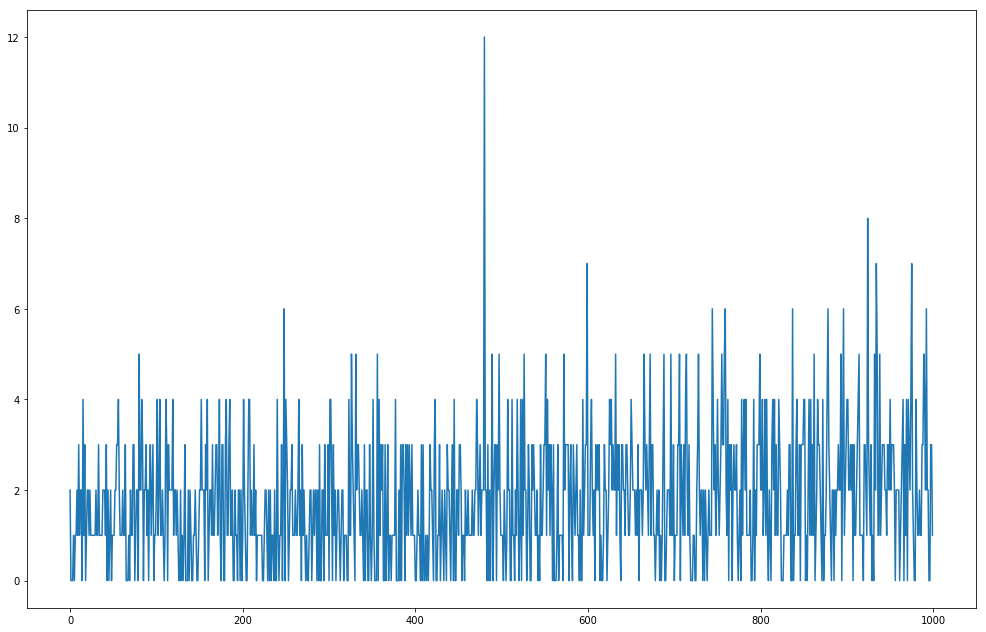

In [31]:
plt.figure(figsize=(17,11))
plt.plot(episode_scores)
plt.show()

# Saving Model

In [32]:
model.save("breakout-atari-rl.h5")

# Testing the Model

In [33]:
mod = load_model("breakout-atari-rl.h5")

In [36]:

env = gym.make("Breakout-v0")
observation = env.reset()
observation, lives = process_obs(observation)

episodes = 10
done = False
epsilon = 0


for i in range(1, episodes+1):
    print("Welcome to AI Breakout!")
    print("Starting Game {} of {}...".format(i, episodes))
    
    sum = 0
    frame = 1
    game = True
    observation_batch = []
    while game:
        
        if (frame == 1):
            action = 1              
        else:
            if (frame - 1) % 4 == 0:
                action = np.argmax(mod.predict(states)) 

                if np.array_equal(states[0][:84,:84,2], states[0][:84,:84,3]):
                    action = 1
                else:
                    pass
                
                observation_batch = []                
            else:
                pass
            
        
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        observation_batch.append(observation)
        
        if (frame % 4 == 0):
            states = np.concatenate([i for i in observation_batch], axis=-1)
            states = np.expand_dims(states,0)


        sum += reward
        frame += 1
        time.sleep(0.02)
        env.render()

        if done:
            print("Total game score was: {}\n".format(int(sum)))
            observation = env.reset()
            observation, lives = process_obs(observation)
            game = False
env.close()        



/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Welcome to AI Breakout!
Starting Game 1 of 10...
Total game score was: 4

Welcome to AI Breakout!
Starting Game 2 of 10...
Total game score was: 4

Welcome to AI Breakout!
Starting Game 3 of 10...
Total game score was: 2

Welcome to AI Breakout!
Starting Game 4 of 10...
Total game score was: 1

Welcome to AI Breakout!
Starting Game 5 of 10...
Total game score was: 3

Welcome to AI Breakout!
Starting Game 6 of 10...
Total game score was: 2

Welcome to AI Breakout!
Starting Game 7 of 10...
Total game score was: 1

Welcome to AI Breakout!
Starting Game 8 of 10...
Total game score was: 2

Welcome to AI Breakout!
Starting Game 9 of 10...
Total game score was: 2

Welcome to AI Breakout!
Starting Game 10 of 10...
Total game score was: 4

